In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.model_selection import KFold, StratifiedKFold

from lightgbm import LGBMClassifier

from scipy.stats import ranksums

In [26]:
!pip install bayesian-optimization

  Running setup.py bdist_wheel for bayesian-optimization ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/f5/ef/5c/9ff1d2d86ad1117bf4cd3f989356ae46fa907014ece63b09dd
Successfully built bayesian-optimization


In [27]:
from bayes_opt import BayesianOptimization

In [2]:
def corr_feature_with_target(feature, target):
    c0 = feature[target == 0].dropna()
    c1 = feature[target == 1].dropna()
        
    if set(feature.unique()) == set([0, 1]):
        diff = abs(c0.mean(axis = 0) - c1.mean(axis = 0))
    else:
        diff = abs(c0.median(axis = 0) - c1.median(axis = 0))
        
    p = ranksums(c0, c1)[1] if ((len(c0) >= 20) & (len(c1) >= 20)) else 2
        
    return [diff, p]

In [3]:
def clean_data(data):
    warnings.simplefilter(action = 'ignore')
    
    # Removing empty features
    nun = data.nunique()
    empty = list(nun[nun <= 1].index)
    
    data.drop(empty, axis = 1, inplace = True)
    print('After removing empty features there are {0:d} features'.format(data.shape[1]))
    data.to_csv('../Input/Aggregated_removed_empty')
    # Removing features with the same distribution on 0 and 1 classes
    corr = pd.DataFrame(index = ['diff', 'p'])
    ind = data[data['TARGET'].notnull()].index
    
    for c in data.columns.drop('TARGET'):
        corr[c] = corr_feature_with_target(data.loc[ind, c], data.loc[ind, 'TARGET'])

    corr = corr.T
    corr['diff_norm'] = abs(corr['diff'] / data.mean(axis = 0))
    
    to_del_1 = corr[((corr['diff'] == 0) & (corr['p'] > .05))].index
    to_del_2 = corr[((corr['diff_norm'] < .5) & (corr['p'] > .05))].drop(to_del_1).index
    to_del = list(to_del_1) + list(to_del_2)
    if 'SK_ID_CURR' in to_del:
        to_del.remove('SK_ID_CURR')
        
    data.drop(to_del, axis = 1, inplace = True)
    print('After removing features with the same distribution on 0 and 1 classes there are {0:d} features'.format(data.shape[1]))
    
    # Removing features with not the same distribution on train and test datasets
    corr_test = pd.DataFrame(index = ['diff', 'p'])
    target = data['TARGET'].notnull().astype(int)
    
    for c in data.columns.drop('TARGET'):
        corr_test[c] = corr_feature_with_target(data[c], target)

    corr_test = corr_test.T
    corr_test['diff_norm'] = abs(corr_test['diff'] / data.mean(axis = 0))
    
    bad_features = corr_test[((corr_test['p'] < .05) & (corr_test['diff_norm'] > 1))].index
    bad_features = corr.loc[bad_features][corr['diff_norm'] == 0].index
    
    data.drop(bad_features, axis = 1, inplace = True)
    print('After removing features with not the same distribution on train and test datasets there are {0:d} features'.format(data.shape[1]))
    
    del corr, corr_test
    gc.collect()
    
    # Removing features not interesting for classifier
    clf = LGBMClassifier(random_state = 0)
    train_index = data[data['TARGET'].notnull()].index
    train_columns = data.drop('TARGET', axis = 1).columns

    score = 1
    new_columns = []
    while score > .7:
        train_columns = train_columns.drop(new_columns)
        clf.fit(data.loc[train_index, train_columns], data.loc[train_index, 'TARGET'])
        f_imp = pd.Series(clf.feature_importances_, index = train_columns)
        score = roc_auc_score(data.loc[train_index, 'TARGET'], 
                              clf.predict_proba(data.loc[train_index, train_columns])[:, 1])
        new_columns = f_imp[f_imp > 0].index

    data.drop(train_columns, axis = 1, inplace = True)
    print('After removing features not interesting for classifier there are {0:d} features'.format(data.shape[1]))

    return data

In [4]:
df = pd.read_csv('../Input/feature_matrix_advanced.csv')

In [5]:
# Label encode
from sklearn.preprocessing import LabelEncoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in df:
    if df[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(df[col].unique())) <= 2:
            # Train on the training data
            le.fit(df[col])
            # Transform both training and testing data
            df[col] = le.transform(df[col])
            #app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

# one-hot encoding of categorical variables

df = pd.get_dummies(df)

4 columns were label encoded.


In [12]:
df['TARGET'].head()

0    NaN
1    1.0
2    0.0
3    0.0
4    NaN
Name: TARGET, dtype: float64

In [13]:
def cv_scores(df, num_folds, params, stratified = False, verbose = -1, 
              save_train_prediction = False, train_prediction_file_name = 'train_prediction.csv',
              save_test_prediction = True, test_prediction_file_name = 'test_prediction.csv'):
    warnings.simplefilter('ignore')
    
    clf = LGBMClassifier(**params)

    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 1001)
    else:
        folds = KFold(n_splits = num_folds, shuffle = True, random_state = 1001)
        
    # Create arrays and dataframes to store results
    train_pred = np.zeros(train_df.shape[0])
    train_pred_proba = np.zeros(train_df.shape[0])

    test_pred = np.zeros(train_df.shape[0])
    test_pred_proba = np.zeros(train_df.shape[0])
    
    prediction = np.zeros(test_df.shape[0])
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    df_feature_importance = pd.DataFrame(index = feats)
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        print('Fold', n_fold, 'started at', time.ctime())
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = verbose, early_stopping_rounds = 200)

        train_pred[train_idx] = clf.predict(train_x, num_iteration = clf.best_iteration_)
        train_pred_proba[train_idx] = clf.predict_proba(train_x, num_iteration = clf.best_iteration_)[:, 1]
        test_pred[valid_idx] = clf.predict(valid_x, num_iteration = clf.best_iteration_)
        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        prediction += \
                clf.predict_proba(test_df[feats], num_iteration = clf.best_iteration_)[:, 1] / folds.n_splits

        df_feature_importance[n_fold] = pd.Series(clf.feature_importances_, index = feats)
        
        print('Fold %2d AUC : %.6f' % (n_fold, roc_auc_score(valid_y, test_pred_proba[valid_idx])))
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    roc_auc_train = roc_auc_score(train_df['TARGET'], train_pred_proba)
    precision_train = precision_score(train_df['TARGET'], train_pred, average = None)
    recall_train = recall_score(train_df['TARGET'], train_pred, average = None)
    
    roc_auc_test = roc_auc_score(train_df['TARGET'], test_pred_proba)
    precision_test = precision_score(train_df['TARGET'], test_pred, average = None)
    recall_test = recall_score(train_df['TARGET'], test_pred, average = None)

    print('Full AUC score %.6f' % roc_auc_test)
    
    df_feature_importance.fillna(0, inplace = True)
    df_feature_importance['mean'] = df_feature_importance.mean(axis = 1)
    
    # Write prediction files
    if save_train_prediction:
        df_prediction = train_df[['SK_ID_CURR', 'TARGET']]
        df_prediction['Prediction'] = test_pred_proba
        df_prediction.to_csv(train_prediction_file_name, index = False)
        del df_prediction
        gc.collect()

    if save_test_prediction:
        df_prediction = test_df[['SK_ID_CURR']]
        df_prediction['TARGET'] = prediction
        df_prediction.to_csv(test_prediction_file_name, index = False)
        del df_prediction
        gc.collect()
    
    return df_feature_importance, \
           [roc_auc_train, roc_auc_test,
            precision_train[0], precision_test[0], precision_train[1], precision_test[1],
            recall_train[0], recall_test[0], recall_train[1], recall_test[1], 0]

In [14]:
def display_folds_importances(feature_importance_df_, n_folds = 5):
    n_columns = 3
    n_rows = (n_folds + 1) // n_columns
    _, axes = plt.subplots(n_rows, n_columns, figsize=(8 * n_columns, 8 * n_rows))
    for i in range(n_folds):
        sns.barplot(x = i, y = 'index', data = feature_importance_df_.reset_index().sort_values(i, ascending = False).head(20), 
                    ax = axes[i // n_columns, i % n_columns])
    sns.barplot(x = 'mean', y = 'index', data = feature_importance_df_.reset_index().sort_values('mean', ascending = False).head(20), 
                    ax = axes[n_rows - 1, n_columns - 1])
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()

In [15]:
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
lgbm_params = {
            'nthread': -1,
            'n_estimators': 10000,
            'learning_rate': .02,
            'num_leaves': 34,
            'colsample_bytree': .9497036,
            'subsample': .8715623,
            'max_depth': 8,
            'reg_alpha': .041545473,
            'reg_lambda': .0735294,
            'min_split_gain': .0222415,
            'min_child_weight': 39.3259775,
            'silent': -1,
            'verbose': -1
}

In [16]:
feature_importance, scor = cv_scores(df, 5, lgbm_params, test_prediction_file_name = '../Submissions/prediction_full_auto_features.csv')

Starting LightGBM. Train shape: (307511, 4075), test shape: (48744, 4075)
Fold 0 started at Thu Aug  9 01:10:19 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1300]	training's auc: 0.878727	valid_1's auc: 0.78967
Fold  0 AUC : 0.789670
Fold 1 started at Thu Aug  9 01:24:23 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1646]	training's auc: 0.894432	valid_1's auc: 0.790357
Fold  1 AUC : 0.790357
Fold 2 started at Thu Aug  9 01:39:26 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1797]	training's auc: 0.90087	valid_1's auc: 0.784204
Fold  2 AUC : 0.784204
Fold 3 started at Thu Aug  9 01:55:46 2018
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1287]	training's auc: 0.880478	valid_1's auc: 0.784507
Fold  3 AUC : 0.784507
Fold 4 started at Thu Aug  9 02:09:25 2018
Train

In [19]:
step = 'Tilii`s Bayesian optimization'

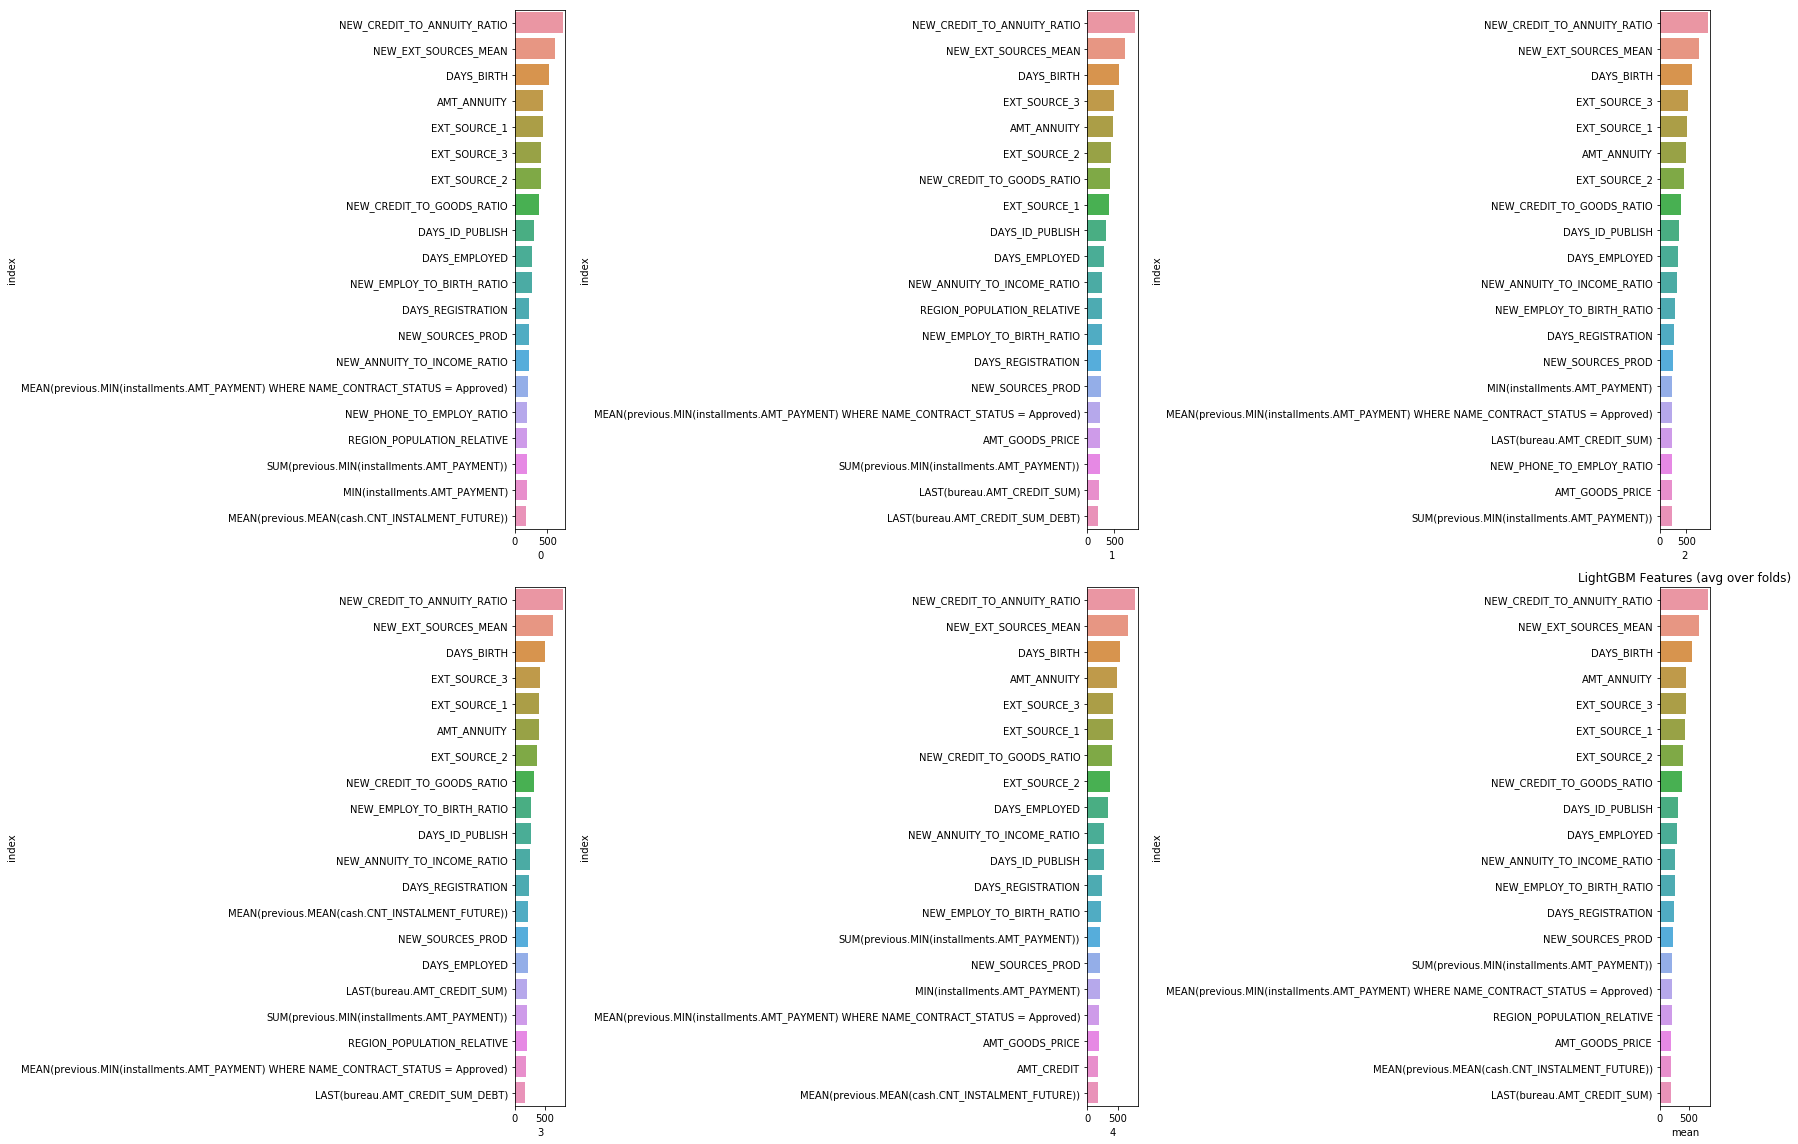

In [20]:
display_folds_importances(feature_importance)

In [21]:
feature_importance[feature_importance['mean'] == 0].shape

(2057, 6)

In [22]:
feature_importance.sort_values('mean', ascending = False).head(20)

,0,1,2,3,4,mean
NEW_CREDIT_TO_ANNUITY_RATIO,738,889,906,808,779,824.0
NEW_EXT_SOURCES_MEAN,614,701,743,640,654,670.4
DAYS_BIRTH,522,583,601,504,526,547.2
AMT_ANNUITY,430,485,494,401,478,457.6
EXT_SOURCE_3,406,499,530,419,423,455.4
EXT_SOURCE_1,430,410,518,411,412,436.2
EXT_SOURCE_2,406,443,460,366,361,407.2
NEW_CREDIT_TO_GOODS_RATIO,378,419,407,328,396,385.6
DAYS_ID_PUBLISH,302,346,363,277,267,311.0
DAYS_EMPLOYED,267,313,345,220,337,296.4


In [23]:
def lgbm_evaluate(**params):
    warnings.simplefilter('ignore')
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
        
    clf = LGBMClassifier(**params, n_estimators = 10000, nthread = 4)

    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]

    folds = KFold(n_splits = 2, shuffle = True, random_state = 1001)
        
    test_pred_proba = np.zeros(train_df.shape[0])
    
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        clf.fit(train_x, train_y, 
                eval_set = [(train_x, train_y), (valid_x, valid_y)], eval_metric = 'auc', 
                verbose = False, early_stopping_rounds = 100)

        test_pred_proba[valid_idx] = clf.predict_proba(valid_x, num_iteration = clf.best_iteration_)[:, 1]
        
        del train_x, train_y, valid_x, valid_y
        gc.collect()

    return roc_auc_score(train_df['TARGET'], test_pred_proba)

In [24]:
params = {'colsample_bytree': (.7, 0.8, 1),
          'learning_rate': (.001, .01, .02, .03), 
          'num_leaves': (33, 34, 35, 38, 40), 
          'subsample': (.6, .7, 0.8, 1), 
          'max_depth': (7,8,9,10,12), 
          'reg_alpha': (.02, .03, .05, .07), 
          'reg_lambda': (.04, .06, .08 ,.1), 
          'min_split_gain': (.01, .03, .05),
          'min_child_weight': (38, 40, 42, 44, 46, 50)}

In [33]:
params = {'colsample_bytree': (0.7, 1),
          'learning_rate': (.001, .02), 
          'num_leaves': (33, 40), 
          'subsample': (0.7, 1), 
          'max_depth': (7, 13), 
          'reg_alpha': (.03, .05), 
          'reg_lambda': (.06, .08), 
          'min_split_gain': (.01, .03),
          'min_child_weight': (38, 50)}

In [34]:
bo = BayesianOptimization(lgbm_evaluate, params)
bo.maximize(init_points = 5, n_iter = 25)
best_params = bo.res['max']['max_params']
best_params['num_leaves'] = int(best_params['num_leaves'])
best_params['max_depth'] = int(best_params['max_depth'])

best_params

Initialization
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |   learning_rate |   max_depth |   min_child_weight |   min_split_gain |   num_leaves |   reg_alpha |   reg_lambda |   subsample | 
    1 | 36m27s |    0.78333 |             0.9369 |          0.0174 |      9.3172 |            45.5884 |           0.0189 |      38.5535 |      0.0479 |       0.0724 |      0.8431 | 
    2 | 98m02s |    0.78350 |             0.9332 |          0.0057 |     11.6953 |            41.2819 |           0.0212 |      39.2196 |      0.0395 |       0.0704 |      0.8390 | 


KeyboardInterrupt: 

In [ ]:
bo.res['max']['max_val']
feature_importance, scor = cv_scores(df, 5, best_params, test_prediction_file_name = 'prediction_bayes_opt_1.csv')